In [1]:
%load_ext autoreload
%autoreload 2
import sys
# do this to be able to import the custom python scripts
sys.path.insert(1, "../../../python_scripts")
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import dedupe 

import dm_diagnostics as dmd
import dm_utils
import dm_plots
import dm_file_checker
from sklearn.metrics import confusion_matrix, accuracy_score

import json

## Get Appropriate Filepaths

In [2]:
saved_files_path = "../../../saved_files"
task_name = os.path.basename(os.getcwd())
    
# files to be read in
is_data_source_deduped = dm_file_checker.check_is_data_source_deduped(task_name, saved_files_path)
settings_filepath =  dm_file_checker.get_filepath(task_name, "model_settings", saved_files_path)
labeled_data_filepath = dm_file_checker.get_filepath(task_name, "labeled_data", saved_files_path)
blocks_filepath = dm_file_checker.get_filepath(task_name, "blocks", saved_files_path)

# files to be written out
mapped_records_filepath = dm_file_checker.get_filepath(task_name, "mapped_records", saved_files_path)
model_weights_filepath = dm_file_checker.get_filepath(task_name, "model_weights", saved_files_path)
labeled_pair_ids_filepath = dm_file_checker.get_filepath(task_name, "labeled_pair_ids", saved_files_path)

## Setup: Reading in Unlabeled Data, Labeled Data, and Trained Model

In [3]:
if is_data_source_deduped:
    unlabeled_data_1, unlabeled_data_2 = dm_utils.get_deduped_data_for_rl(task_name, saved_files_path)
    print("Using canonicalized deduped dataset instead of the original preprocessed data.")
else:
    unlabeled_data_1_filepath, unlabeled_data_2_filepath = dm_file_checker.get_proper_unlabeled_data_filepath(task_name, saved_files_path)
    print("Not using the canonicalized deduped dataset. Using the original preprocessed data.")
    
    numeric_fields_1, numeric_fields_2 = dm_file_checker.get_dataset_info(task_name, "numeric_fields", saved_files_path)
    print("Numeric fields 1 are {}".format(numeric_fields_1))
    print("Numeric fields 2 are {}".format(numeric_fields_2))
    
    unlabeled_data_1 = dm_utils.read_unlabeled_data_json(unlabeled_data_1_filepath, numeric_fields = numeric_fields_1)
    unlabeled_data_2 = dm_utils.read_unlabeled_data_json(unlabeled_data_2_filepath, numeric_fields = numeric_fields_2)

Not using the canonicalized deduped dataset. Using the original preprocessed data.
Numeric fields 1 are []
Numeric fields 2 are []
converting 94 empty string values of column date_of_birth to None
converting 112 empty string values of column given_name to None
converting 48 empty string values of column surname to None
converting 158 empty string values of column street_number to None
converting 98 empty string values of column address_1 to None
converting 420 empty string values of column address_2 to None
converting 55 empty string values of column suburb to None
converting 0 empty string values of column postcode to None
converting 50 empty string values of column state to None
converting 0 empty string values of column soc_sec_id to None
converting 263 empty string values of column date_of_birth to None
converting 234 empty string values of column given_name to None
converting 102 empty string values of column surname to None
converting 287 empty string values of column street_numb

In [4]:
# reading in trained model
with open(settings_filepath, 'rb') as f:
    linker = dedupe.StaticRecordLink(f)

# reading in labeled data
with open(labeled_data_filepath, "r") as json_file:
    labeled_data = json.load(json_file)

INFO:dedupe.api:((LevenshteinSearchPredicate: (2, postcode), LevenshteinSearchPredicate: (2, soc_sec_id)), (SimplePredicate: (dayPredicate, date_of_birth), TfidfTextSearchPredicate: (0.2, address_1)), (SimplePredicate: (commonIntegerPredicate, address_2), SimplePredicate: (sortedAcronym, address_1)), (SimplePredicate: (commonIntegerPredicate, address_2), SimplePredicate: (commonTwoTokens, suburb)), (SimplePredicate: (commonThreeTokens, suburb), TfidfNGramSearchPredicate: (0.4, surname)), (SimplePredicate: (commonThreeTokens, address_2), SimplePredicate: (twoGramFingerprint, surname)))


## Finding Record IDs of Labeled Data

In [5]:
labeled_pairs_df = dm_utils.find_ids_of_labeled_data_rl(labeled_data, unlabeled_data_1, unlabeled_data_2)
labeled_pairs_df.to_csv(labeled_pair_ids_filepath, index = False, encoding = "utf-8")
labeled_pairs_df

 26%|██▌       | 16/61 [00:00<00:00, 150.40it/s]

Finding ids for distinct pairs


 31%|███       | 24/78 [00:00<00:00, 235.03it/s]

Finding ids for match pairs


100%|██████████| 78/78 [00:00<00:00, 223.52it/s]


,record id 1,record id 2,label
0,febrl4a-rec-4751-org,febrl4b-rec-1657-dup-0,distinct
1,febrl4a-rec-2727-org,febrl4b-rec-3637-dup-0,distinct
2,febrl4a-rec-1221-org,febrl4b-rec-4758-dup-0,distinct
3,febrl4a-rec-11-org,febrl4b-rec-3489-dup-0,distinct
4,febrl4a-rec-4607-org,febrl4b-rec-375-dup-0,distinct
...,...,...,...
134,febrl4a-rec-802-org,febrl4b-rec-802-dup-0,match
135,febrl4a-rec-3980-org,febrl4b-rec-3980-dup-0,match
136,febrl4a-rec-4242-org,febrl4b-rec-4242-dup-0,match
137,febrl4a-rec-22-org,febrl4b-rec-22-dup-0,match


## Predicates for Indexing/Blocking

In [6]:
linker.predicates

((LevenshteinSearchPredicate: (2, postcode),
  LevenshteinSearchPredicate: (2, soc_sec_id)),
 (SimplePredicate: (dayPredicate, date_of_birth),
  TfidfTextSearchPredicate: (0.2, address_1)),
 (SimplePredicate: (commonIntegerPredicate, address_2),
  SimplePredicate: (sortedAcronym, address_1)),
 (SimplePredicate: (commonIntegerPredicate, address_2),
  SimplePredicate: (commonTwoTokens, suburb)),
 (SimplePredicate: (commonThreeTokens, suburb),
  TfidfNGramSearchPredicate: (0.4, surname)),
 (SimplePredicate: (commonThreeTokens, address_2),
  SimplePredicate: (twoGramFingerprint, surname)))

## Model Weights

In [7]:
# checking model weights
model_weights = dm_utils.get_model_weights(linker)
model_weights.to_csv(model_weights_filepath, index = False, encoding = "utf-8")
model_weights

,variable,logistic_reg_weight
0,(soc_sec_id: ShortString),-5.463801
1,(postcode: ShortString),-5.420141
2,(address_2: String),-4.240071
3,(surname: String),-3.246548
4,(state: ShortString),-3.230737
5,(street_number: ShortString),-2.699601
6,(given_name: String),-2.185524
7,(address_1: String),-1.471259
8,((state: ShortString): Not Missing),-0.714482
9,(seconds: Dummy),-0.369167


## Thresholding
- Includes diagnostic plots to justify and explain the threshold

In [8]:
%%time
# Find the threshold that will maximize a weighted average of our
# precision and recall.  When we set the recall weight to 2, we are
# saying we care twice as much about recall as we do precision.
#
# If we had more data, we would not pass in all the blocked data into
# this function but a representative sample.
blocked_data = dm_utils.read_linker_blocks(unlabeled_data_1, unlabeled_data_2, blocks_filepath)
probs, threshold = dm_utils.get_linker_probs_and_threshold(linker, unlabeled_data_1, unlabeled_data_2, 
                                                           blocked_data = blocked_data,
                                                           recall_weight=1)

Maximum expected recall and precision
recall: 99.96%
precision: 99.94%
With threshold: 52.13%
CPU times: user 16.7 s, sys: 2.1 s, total: 18.8 s
Wall time: 42.5 s


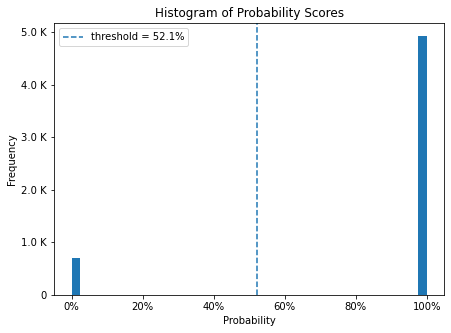

In [9]:
dm_plots.plot_prob_histogram(probs,threshold)

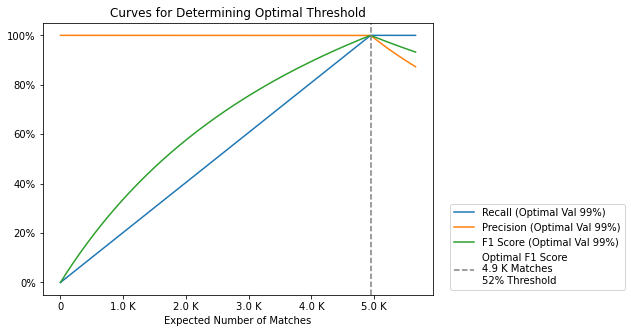

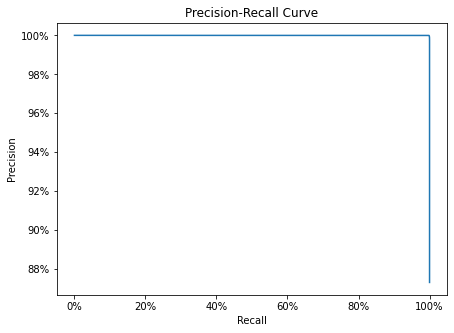

In [10]:
dm_plots.plot_threshold_finder_curves(probs,threshold,recall_weight = 1)

## Clustering and Canonicalization

In [11]:
%%time
blocked_data = dm_utils.read_linker_blocks(unlabeled_data_1, unlabeled_data_2, blocks_filepath)
mapped_records_df  = dm_utils.get_linked_ids(linker, unlabeled_data_1, unlabeled_data_2, threshold, blocked_data = blocked_data)

mapped_records_df.to_csv(mapped_records_filepath, index = False, encoding = "utf-8")

100%|██████████| 67/67 [00:00<00:00, 139049.17it/s]

Mapping linked pairs...
Mapping unlinked records in dataset 1...
Mapping unlinked records in dataset 2...
CPU times: user 17.1 s, sys: 1.75 s, total: 18.8 s
Wall time: 44.2 s


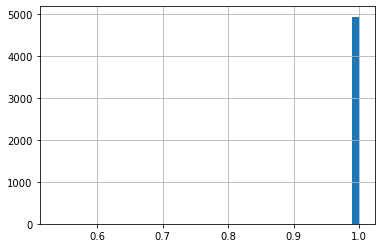

In [12]:
mapped_records_df["confidence score"].hist(bins = 40)
plt.show()

## Summary Report

In [13]:
n_total_records = len(unlabeled_data_1) + len(unlabeled_data_2)
print("Total Number of Records\n{:,}".format(n_total_records))

n_unique_records = mapped_records_df.shape[0]
print("Total Number of Unique Persons after Linking\n{:,}".format(n_unique_records))

print("")
n_duplicates = (mapped_records_df["link type"] == "dup").sum()
print("Number of paired records\n{:,}".format(n_duplicates))

n_solo_records_1 = mapped_records_df.loc[mapped_records_df["link type"] == "solo", "record id 1"].dropna().shape[0]
print("Number of solo records in dataset 1\n{:,}".format(n_solo_records_1))

n_solo_records_2 = mapped_records_df.loc[mapped_records_df["link type"] == "solo", "record id 2"].dropna().shape[0]
print("Number of solo records in dataset 2\n{:,}".format(n_solo_records_2))

Total Number of Records
10,000
Total Number of Unique Persons after Linking
5,067

Number of paired records
4,933
Number of solo records in dataset 1
67
Number of solo records in dataset 2
67


## Training Set Evaluation - Assessing Blocking on Training Data

In [14]:
labeled_pairs_df = pd.read_csv(labeled_pair_ids_filepath)
labeled_pairs_df.head()

,record id 1,record id 2,label
0,febrl4a-rec-4751-org,febrl4b-rec-1657-dup-0,distinct
1,febrl4a-rec-2727-org,febrl4b-rec-3637-dup-0,distinct
2,febrl4a-rec-1221-org,febrl4b-rec-4758-dup-0,distinct
3,febrl4a-rec-11-org,febrl4b-rec-3489-dup-0,distinct
4,febrl4a-rec-4607-org,febrl4b-rec-375-dup-0,distinct


In [15]:
true_links = labeled_pairs_df.loc[labeled_pairs_df["label"] == "match",:]\
                                            .set_index(["record id 1", "record id 2"]).index

In [16]:
labeled_rec_ids = labeled_pairs_df["record id 1"].unique().tolist() + labeled_pairs_df["record id 2"].unique().tolist()

labeled_pairs_data_1 = {rec_id:unlabeled_data_1[rec_id] for rec_id in unlabeled_data_1.keys() if rec_id in labeled_rec_ids}
labeled_pairs_data_2 = {rec_id:unlabeled_data_2[rec_id] for rec_id in unlabeled_data_2.keys() if rec_id in labeled_rec_ids}

candidate_pairs = dm_utils.get_linker_candidate_pairs(linker, labeled_pairs_data_1, labeled_pairs_data_2)

In [17]:
dmd.diagnose_indexing(true_links, candidate_pairs)

Pairs Completeness Ratio
100.00%
Pairs Quality Ratio
93.98%


## Training Set Evaluation - Assessing Classification on Labeled Data

In [18]:
threshold = 0.5

In [19]:
labeled_all_links = labeled_pairs_df.set_index(["record id 1", "record id 2"]).index

In [20]:
candidates = dm_utils.convert_rl_to_linker_candidate_pair(labeled_all_links, unlabeled_data_1, unlabeled_data_2)

candidate_scores = dedupe.core.scoreDuplicates(candidates, linker.data_model, linker.classifier, linker.num_cores)
labeled_pairs_df["score"] = candidate_scores["score"]
labeled_pairs_df.head()

,record id 1,record id 2,label,score
0,febrl4a-rec-4751-org,febrl4b-rec-1657-dup-0,distinct,9.283632e-37
1,febrl4a-rec-2727-org,febrl4b-rec-3637-dup-0,distinct,5.236994e-19
2,febrl4a-rec-1221-org,febrl4b-rec-4758-dup-0,distinct,3.623224e-31
3,febrl4a-rec-11-org,febrl4b-rec-3489-dup-0,distinct,1.517275e-09
4,febrl4a-rec-4607-org,febrl4b-rec-375-dup-0,distinct,1.233242e-31


In [21]:
labeled_pairs_df["predicted label"] = labeled_pairs_df["score"].apply(lambda x: "match" if x > threshold else "distinct")
labeled_pairs_df.head()

,record id 1,record id 2,label,score,predicted label
0,febrl4a-rec-4751-org,febrl4b-rec-1657-dup-0,distinct,9.283632e-37,distinct
1,febrl4a-rec-2727-org,febrl4b-rec-3637-dup-0,distinct,5.236994e-19,distinct
2,febrl4a-rec-1221-org,febrl4b-rec-4758-dup-0,distinct,3.623224e-31,distinct
3,febrl4a-rec-11-org,febrl4b-rec-3489-dup-0,distinct,1.517275e-09,distinct
4,febrl4a-rec-4607-org,febrl4b-rec-375-dup-0,distinct,1.233242e-31,distinct


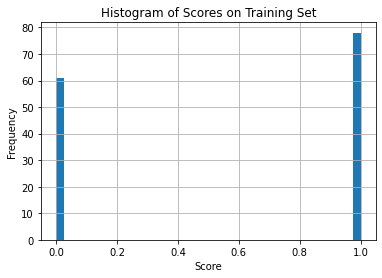

In [22]:
labeled_pairs_df["score"].hist(bins = 40)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Histogram of Scores on Training Set")
plt.show()

In [23]:
y_true = labeled_pairs_df["label"]
y_pred = labeled_pairs_df["predicted label"]
print("Confusion Matrix\n{}".format(confusion_matrix(y_true, y_pred, labels = ["match", "distinct"])))
print("Accuracy Score {:.1f}%".format(accuracy_score(y_true, y_pred)*100))

Confusion Matrix
[[78  0]
 [ 0 61]]
Accuracy Score 100.0%
